# Mesterséges neurális hálók tanítása tensorflow-val

A mai gyakorlaton egy két rejtett réteges neuronhálót tanítunk kézzel írt számok felismerésére.

## Neuronháló

![Neuronháló](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/300px-Colored_neural_network.svg.png)

## MNIST adatbázis

![MNIST adatbázis](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)
<br>
Az adatbázis kézzel írt számokról készült képeket tartalmaz. Összesen 60000 db példa található a tanító adatbázisban és 10000 a teszt halmazban. A képeket egységes méretre hozták (28x28 pixel) és minden pixel intenzitását 0 és 1 közé normalizáltak. A képek 1-D-s numpy tömbökben vannak tárolva.

Bővebben: http://yann.lecun.com/exdb/mnist/

Első lépésben telepítsük a matplotlib csomagot, majd improtáljuk a szükséges csomagokat és letöltjük az adatbázis a /tmp/data könyvtárba.

In [ ]:
#!sudo pip3 install matplotlib
%tensorflow_version 1.15
import tensorflow as tf


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [ ]:
mnist.train.images[0,:]
mnist.train.labels

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

A következő lépés a tanítási paraméterek és a neuronháló strukturához a változók inicializálása.

In [ ]:
# Parameters
learning_rate = 0.1 # 
num_steps = 1000 #   1000 x 120 = 120 000 / 60k => 2 epoch
batch_size = 120 #    
display_step = 100

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 256 # hidden layer's number of neurons
num_classes = 10 # MNIST total classes (0-9 digits)

A neuronháló tanításához létrehozunk egy bemeneti függvényt, ami a korábban letöltött adatbázisból ú.n. batch-eket fog készíteni.

In [ ]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

A következő kód létrehozza az 1 rejtett réteges hálózatot, lineáris aktivációs függvénnyel.

In [ ]:
# Define the neural network
def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_1, num_classes)
    return out_layer

A tanításhoz szükséges dolgok beállítása:
- neuronháló kimenetének kezelése
- loss függvény megadása
- hibametrika választása

In [ ]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

A fenti kódok meghívása, estimator létrehozása.

In [ ]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3wa33paz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f30e0eb0d30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Neuronháló tanítása
Megfigyelhető, hogy minden 100. step után közöl információt és 1000 lépésig fut (ezeket feljebb állítottuk be).
Tanítás során célszerű figyelni a loss értékét, az alapján tudjuk beállítani a tanulási paramétereket.

In [ ]:
# Train the Model
model.train(input_fn, steps=num_steps)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp3wa33paz/model.ckpt.
INFO:tensorflow:loss = 2.3741653, step = 1
INFO:tensorflow:globa

In [ ]:
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-15T08:43:22Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3wa33paz/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


KeyboardInterrupt: ignored

Tanítás után kiértékelünk a teszt halmazon.
**Fontos: csak a legjobb modellünket értékeljük ki a teszt halmazon, különben peeking-elünk.**

Peeking (kukucskálás): a teszt halmazon látott teljesítmény alapján optimalizáljuk az algoritmusunk paramétereit,
 ezért nem tudjuk, hogy az milyen jól általánosít.

In [ ]:
# Magic command

%load_ext tensorboard
%tensorboard --logdir=logs

In [ ]:
mnist.train.labels[-5000:].shape  # train : {'accuracy': 0.9408, 'global_step': 1000, 'loss': 0.21501538}
#                                 lr: 0.1  val:{'accuracy': 0.9208, 'global_step': 1000, 'loss': 0.28486207}
#                                 lr: 0.05  val:{'accuracy': 0.918, 'global_step': 1000, 'loss': 0.29808888}
#                                 lr: 0.25  val:{'accuracy': 0.9222, 'global_step': 2000, 'loss': 0.2769341}
mnist.test.labels.shape

(10000,)

In [ ]:
# Evaluate the Model
# Define the input function for evaluating
input_fn_val = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.validation.images}, y=mnist.validation.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn_val)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-15T08:51:21Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3wa33paz/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-10-15-08:51:22
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9194, global_step = 1000, loss = 0.28516358
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp3wa33paz/model.ckpt-1000


{'accuracy': 0.9194, 'global_step': 1000, 'loss': 0.28516358}

In [ ]:
# Evaluate the Model
# Define the input function for evaluating
input_fn_test = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-10-15T08:52:01Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3wa33paz/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-10-15-08:52:01
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9172, global_step = 1000, loss = 0.29273248
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp3wa33paz/model.ckpt-1000


{'accuracy': 0.9172, 'global_step': 1000, 'loss': 0.29273248}

Kiértékelhetünk csak néhány példát is a következő módon:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpfl6y8cbp/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


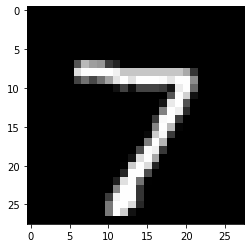

Model prediction: 7


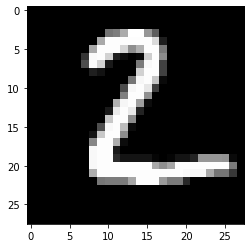

Model prediction: 2


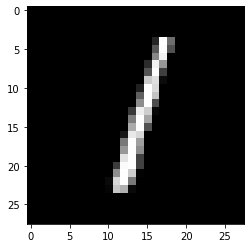

Model prediction: 1


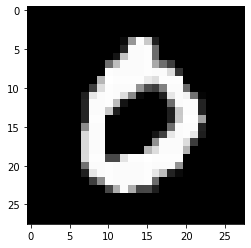

Model prediction: 0


In [ ]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn_test_few = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn_test_few))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

### Feladatok
1. Keressük meg, hogy mely képeken hibázott a háló!
2. Változtassuk a neuronok számát, a batch méretet és a num_step értékét!
3. Adjunk hozzá a neuronhálóhoz további rejtett rétegeket!

### Keras megvalósítás

In [ ]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, sgd

batch_size = 128
num_classes = 10
epochs = 5

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
#model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=sgd(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 932,362
Trainable params: 932,362
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 174us/step - loss: 1.1863 - accuracy: 0.7282 - val_loss: 0.4929 - val_accuracy: 0.8780
Epoch 2/5